In [92]:
import numpy as np
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [93]:
import nnfs
nnfs.init()
dataset=spiral_data(100, 3)

In [94]:
X, y = dataset

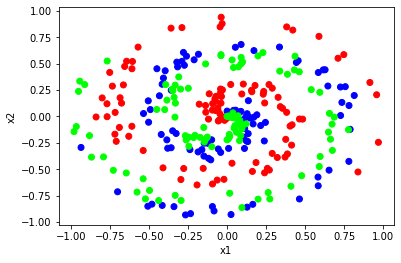

In [95]:
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:,0], X[:, 1], c=y, cmap='brg')
plt.show()

In [96]:
class Relu:
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0 

In [97]:
class Softmax:
    def forward(self, y):
        exp_val = np.exp(y - np.max(y, axis=1, keepdims=True))
        self.outputs = exp_val / np.sum(exp_val, axis=1, keepdims=True)
        return self.outputs 

In [98]:
class Softmax_and_LossCrossEntropy:
    def __init__(self):
        self.lossfunc=Softmax()

    def compute_loss(self, y_true):
        clipped= np.clip(self.output, 1e-7, 1 - 1e-7)
        self.loss = -np.log(clipped[np.arange(len(y_true)), y_true])
        return self.loss

    def forward(self, inputs, y_true):
        self.output = self.lossfunc.forward(inputs)
        self.compute_loss(y_true)

    def backward(self, y_true):
        self.dinputs=self.output.copy()
        self.dinputs[np.arange(len(y_true)), y_true]-=1
        self.dinputs/=len(y_true)

In [99]:
class Optimizer:
    def __init__(self, lr=1.0, decay=0.005, beta=0.9):
        self.lr = lr
        self.init_lr = lr
        self.decay = decay
        self.iter = 0
        self.beta = beta

    def pre_update(self):
        self.lr = self.init_lr / (1 + self.decay * self.iter)

    def update_params(self, layer):
        if not hasattr(layer, "weight_momentum"):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)

        layer.weight_momentum = (
            self.beta * layer.weight_momentum - self.lr * layer.dweights
        )
        layer.bias_momentum = self.beta * layer.bias_momentum - self.lr * layer.dbiases

        layer.weights += layer.weight_momentum
        layer.biases += layer.bias_momentum

    def post_update(self):
        self.iter += 1

In [100]:
class LayerDense:
    def __init__(self, n_inputs:int , n_neurons: int):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases= np.zeros((1, n_neurons))
        self.inputs=np.zeros((1, n_inputs))
        self.weight_momentum=0
        self.bias_momentum=0

    def forward(self, inputs: np.array):
        self.inputs=inputs.copy()
        self.outputs=np.dot(inputs, self.weights)+self.biases

    def backward(self, dvalues):
        self.dweights=np.dot(self.inputs.T, dvalues)
        self.dinputs=np.dot(dvalues, self.weights.T)
        self.dbiases=np.sum(dvalues, axis=0, keepdims=True)

In [101]:
dense1=LayerDense(2, 64)
activation1=Relu()
dense2=LayerDense(64, 3)
activation2=Softmax_and_LossCrossEntropy()

optimizer=Optimizer(lr=1)


In [102]:
epoch=10000
for _ in range(epoch):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs, y)

    #backward pass
    activation2.backward(y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    #updates
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()

In [103]:
def predict(X):
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    return np.argmax(activation2.lossfunc.forward(dense2.outputs), axis=1)

In [104]:
y_pred=predict(X)

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [106]:
print(accuracy_score(y_pred=y_pred, y_true=y))

0.9133333333333333


In [107]:
print(confusion_matrix(y, y_pred))

[[87  2 11]
 [ 4 96  0]
 [ 9  0 91]]


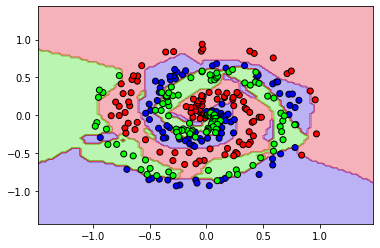

In [108]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid_points) 
Z = Z.reshape(xx.shape)  

plt.contourf(xx, yy, Z, cmap="brg", alpha=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")

plt.show()

In [109]:
np.save("layer1_weights.npy", dense1.weights)
np.save("layer1_biases.npy", dense1.biases) 

np.save("layer2_weights.npy", dense2.weights)
np.save("layer2_biases.npy", dense2.biases)